In [1]:
import os, sys
import argparse
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
from scipy.stats import mode

from tensorboardX import SummaryWriter

from PIL import Image
import cv2

from sklearn.cluster import Birch



### Args:
features_file = "/Users/andreachatrian/Desktop/f1/feats_epoch_.411_loss_0.20396_acc_0.95000_dice_0.93000_lr_0.0000103566.txt"
thumbnails_file = "/Users/andreachatrian/Desktop/f1/thumbnails_epoch_.411_loss_0.20396_acc_0.95000_dice_0.93000_lr_0.0000103566.npy"
sprite_file = "/Users/andreachatrian/Desktop/f1/sprite_epoch_.411_loss_0.20396_acc_0.95000_dice_0.93000_lr_0.0000103566.png"
thumbnail_size = 64
pca_reduce = 2/3
###

# Preprocess

In [2]:
### Preprocessing and visualization ###
run_time = time.time()
with open(features_file, 'r') as feats_file:
    X = np.loadtxt(feats_file, skiprows=1)  # need to skip header row (?)
    #X = X[0:-(170 * 4 + 1), ...] # test glands are repeated
run_time = time.time() - run_time
print("X's shape is ", X.shape)
print("Run in {}s".format(run_time))

X's shape is  (5267, 12096)
Run in 61.11619305610657s


# Embedding

In [7]:
# Check X:
good = np.any(np.isfinite(X))
print(good)

True


In [9]:
# Preprocessing
X = StandardScaler().fit_transform(X)

True


In [10]:
# For t-SNE, PCA is recommended as a first step to reduce dimensionality
run_time = time.time()
pca = PCA(n_components=int(X.shape[1]*pca_reduce), whiten=True)  # reduce number of features
#dec = FastICA(n_components=int(X.shape[1]*pca_reduce), whiten=True, max_iter=200)
# !!! it is possible to generative negative eigenvalue and make the algorithm fail with large matrix that has determinant close to zero
# for ICA, should reduce the number of comoponents to number (rule of thumb, as many as 99% variance explanation in PCA)
pca = pca.fit(X)
X_new = pca.transform(X)
run_time = time.time() - run_time
print("X_new's shape is ", X_new.shape)
print("Run in {}s".format(run_time))

X_new's shape is  (5267, 5267)
Run in 112.33021807670593s


[5.01359774e-01 8.63085802e-02 5.08741189e-02 ... 3.24394861e-35
 1.46880121e-35 2.66028322e-36]
1373


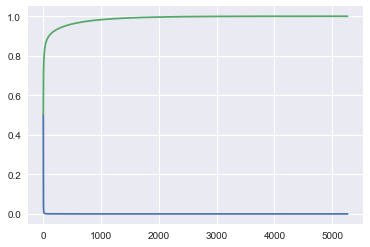

In [20]:
sns.set(style="darkgrid")
plt.plot(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)

cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var)
ninetynine = np.where(cum_var > 0.99)[0][0]
print(ninetynine)

In [23]:
# For t-SNE, PCA is recommended as a first step to reduce dimensionality
run_time = time.time()
dec = FastICA(n_components=ninetynine, whiten=True, max_iter=400)
# !!! it is possible to generative negative eigenvalue and make the algorithm fail with large matrix that has determinant close to zero
# for ICA, should reduce the number of comoponents to number (rule of thumb, as many as 99% variance explanation in PCA)
dec = dec.fit(X)
X_new = dec.transform(X)
run_time = time.time() - run_time
print("X_new's shape is ", X_new.shape)
print("Run in {}s".format(run_time))

X_new's shape is  (5267, 1373)
Run in 596.3380219936371s


In [24]:
# Open thumbnails file
with open(thumbnails_file, 'rb') as tnbs_file:
    thumbnails = np.load(tnbs_file)

In [25]:
# t-SNE with tensorboard
log_dir = Path(features_file).parent/"projector"
try:
    os.mkdir(log_dir)
except FileExistsError:
    pass
writer = SummaryWriter(log_dir=str(log_dir))

In [26]:
X_t = torch.from_numpy(X_new)
thumbnails_t = torch.from_numpy(thumbnails).permute(0,3,1,2).type(torch.float32)  # turn to NCHW for tensorboardX embedding
print(X_t.shape)
print(thumbnails_t.shape)
writer.add_embedding(X_t, label_img=thumbnails_t)

torch.Size([5267, 1373])
torch.Size([5267, 3, 100, 100])


In [ ]:
print(thumbnails.shape)
print(np.unique(thumbnails))


In [ ]:
"""
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector


tf_X = tf.Variable(X_new, trainable=False)
saver = tf.train.Saver([tf_X])

# based on https://www.easy-tensorflow.com/tf-tutorials/tensorboard/tb-embedding-visualization
# http://www.pinchofintelligence.com/simple-introduction-to-tensorboard-embedding-visualisation/

th_size = (100,) * 2
with tf.Session() as sess:

    sess.run(tf_X.initializer)

    writer = tf.summary.FileWriter(str(log_dir /"projector"), sess.graph)

    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = 'embeddingding:0'
    embedding.sprite.image_path = str(log_dir/"projector"/sprite_file)
    projector.visualize_embeddings(summary_writer=writer, config=config)
    
    dir(embedding.sprite)
import inspect
inspect.getmembers(embedding.sprite)

"""

# Clustering

In [ ]:
### Clustering
birch = Birch(threshold=0.5, branching_factor=50, n_clusters=3)
birch.fit(X_new)
labels = birch.predict(X_new)


In [ ]:
import sys
sys.executable